## Depth-1 Neural Network for Classical Linear Regression

The classical linear regression admits an observed matrix of random variable $X$ and the corresponding vector of random variable $Y$. The model assumes that $\vec{x_i}$ for $i = 1...p$ in $X\in R^{n\times p}$ are iid. normally distributed, and the conditional mean of $Y$ depends on $X$ has a linear relationship with some parameters. Namely,

$$
    E[Y|X=x] = \hat{Y} = Xw + b
$$

where $w$ and $b$ are unknown.

## Loss Function

The common loss function for linear regression is squared $L^2$ Norm which quantifies the distance between two surfaces. 
$$
L(w,b) = \sum_{i\in[n]}(\hat{y_i}-y_i)^2 = ||\hat{Y} - Y||^2_2

Note that, unlike most models, linear regression has an analytical solutions:
$$
w^* = (X^TX)^{-1}X^TY
$$

## Minibatch Optimization
Both GD and SGD algorithm have notable drawbacks in practial application. The intermediate approach, minibatch SGD, is often used. Let $B$ be a fixed number of training samples, define the update rule to be:
$$
w_{t+1} = w_t - \frac{\eta}{|B_t|}\sum_{i\in B_t}\partial_{w_t}l^{(i)}(w,b)

Remark: Based on the normality assumption of the data, we can deduce that the Maximum Likelihood Method is equivalent to Minimizing the Squared Loss if we omit the nuissance parameter $\sigma^2$.

## Synthesize Toy Data

Recall that the actual model in simple linear regression is 
$$
Y = Xw + b + \epsilon
$$
where $\epsilon \sim N(0, \sigma)$.

In [1]:
import dl
import torch as tor
import random
from typing import Generator

%load_ext autoreload
%autoreload 2

class ToyRegressionData(dl.DataModule):
    def __init__(self, w, b, eps_var=1, num_train=1000, num_val=100, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tor.randn(n, len(w))
        noise = tor.normal(
            mean = dl.make_vec_single(0, n),
            std = dl.make_vec_single(b, n)
        )
        self.y = tor.matmul(self.X, w.reshape(-1, 1)) + b + noise.reshape(-1, 1)
    
    #override
    def get_dataloader(self, train=True):
        if train:
            indices = list(range(0, self.num_train))
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train+self.num_val))
        
        for i in range(0, len(indices), self.batch_size):
            batch_indices = tor.tensor(indices[i: i + self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]
    
    def __len__(self):
        return self.num_train // self.batch_size

In [2]:
# Example

d = ToyRegressionData(w=tor.tensor([1,2,3], dtype=tor.float32), b=4)
[print(item.shape) for item in next(d.get_dataloader())];

torch.Size([32, 3])
torch.Size([32, 1])


## Model Definition
Any pyroch deep learning model should be a subclass of `Module` class. Tree basic definition should be implemented\overwritten by the actual model:
- `__init__` method initializes the weight appropirately
- `forward` method defines the network architecture
- `loss` method computes the current loss

In [3]:
class LinearRegression(dl.Module):
    def __init__(self, P, eta, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.w = tor.normal(0, sigma, (P, 1), requires_grad=True)
        self.b = tor.zeros(1, requires_grad=True)
    
    def forward(self, X):
        return tor.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2
        return l.mean()

## Optimizer Definition
An optimizer is the implementation of the optimization algorithm. It is a subclass of `HyperParameter` class. The `configure_optimizer` method in `Module` class adjust the optimizer appropriately. Note that gradient calculation is achieved through the built-in `TORCH.autograd` function and no explicit form is required.

In [4]:
class SGD(dl.HyperPrameters):
    def __init__(self, params, eta):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.eta * param.grad
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@dl.add_to_class(LinearRegression)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.eta)

## Training Module

With initial parameters, loss function, model, and optimizer, we can now implement the iterative training process. **Epoch** is a hyperparameter specifying how many times the entire dataset is fed into the model (since data points are passed in the form of mini batch).

In [16]:
@dl.add_to_class(dl.Trainer)
def prepare_batch(self, batch):
    return batch

@dl.add_to_class(dl.Trainer)
def fit_epoch(self):
    #self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.train_loss.append(loss.item())
        self.optim.zero_grad()
        with tor.no_grad():
            loss.backward()
            self.optim.step()
%pdb

Automatic pdb calling has been turned OFF


In [33]:
model = LinearRegression(3, 0.1)
data = ToyRegressionData(
    w = tor.tensor([[1], [2], [3]], dtype=tor.float32),
    b = 1
)
trainer = dl.Trainer(max_epochs=100)
trainer.fit(model, data)

In [34]:
trainer.optim.params

[tensor([[1.1031],
         [2.0111],
         [2.9366]], requires_grad=True),
 tensor([1.0242], requires_grad=True)]

In [36]:
import numpy as np

X = data.X.numpy()
Y = data.y.numpy()

X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
np.linalg.inv(X.T@X)@X.T@Y

array([[0.9867161 ],
       [1.97385923],
       [2.98279816],
       [0.99965218]])

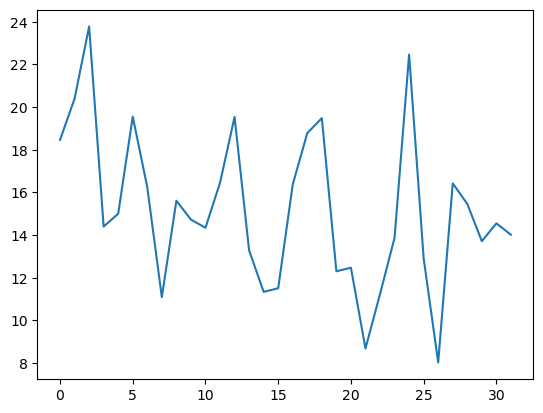

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(trainer.train_loss)), trainer.train_loss)